<a href="https://colab.research.google.com/github/elliemci/building-LLM/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pretraining on Unlabeled Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/LLM
%ls

/content/drive/MyDrive/Colab Notebooks/LLM
attention_comp.ipynb      gpt_model.png                  sliding_window_sampling.py  training.ipynb
attention_comp.py         __pycache__/                   the-verdict.txt
gpt_implementation.ipynb  pytorch_wormup.ipynb           token_embedding.ipynb
gpt_implementation.py     sliding_window_sampling.ipynb  tokenizing_text.ipynb


In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.0 MB/s eta 0:00:00


In [ ]:
! jupyter nbconvert --to python gpt_implementation.ipynb

[NbConvertApp] Converting notebook gpt_implementation.ipynb to python
[NbConvertApp] Writing 18539 bytes to gpt_implementation.py


In [ ]:
! jupyter nbconvert --to python sliding_window_sampling.ipynb

[NbConvertApp] Converting notebook sliding_window_sampling.ipynb to python
[NbConvertApp] Writing 4643 bytes to sliding_window_sampling.py


In [ ]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False}

In [ ]:
from gpt_implementation import GPTModel

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.eval()

## Model Evaluation

### Text Generation

Three-step text generation process:
1. Convert input text into a series of token IDs
2. Model generates coresponding logits, probability distribution for each token in the vocabulary
3. Convert logits back into token IDs, decoded with tokenizer into text

#### Utility functions

In [ ]:
import tiktoken
from gpt_implementation import generate_text_simple

def text_to_token_ids(text, tokenizer, device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(device) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


In [ ]:
# Text into tokens
start_context = "Every effort moves you"

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer, device=None),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print(f"Input text:\n{start_context}")
print(f"\nOutput text:\n{token_ids_to_text(token_ids, tokenizer)}")

Input text:
Every effort moves you

Output text:
Every effort moves you?"

"Yes--quite insensible to


In [ ]:
text_to_token_ids(start_context, tokenizer)

tensor([[6109, 3626, 6100,  345]])

In [ ]:
text1 = "every effort moves you"
text2 = "I really like learning"

text1_tokens = text_to_token_ids(text1, tokenizer)
text2_tokens = text_to_token_ids(text2, tokenizer)

print(text1_tokens)
print(text2_tokens)

#inputs = torch.cat((text1_tokens, text2_tokens), 0)
inputs = torch.tensor([[16833,  3626,  6100],
                       [   40,  1107,   588]])
print(f"input tokens:\n{inputs}")
targets =  torch.tensor([[3626,  6100,   345],
                         [1107,   588,  4673]])
# output logit
with torch.no_grad():
    logits = model(inputs)

# Probability of each token in vocabulary
probas = torch.softmax(logits, dim=-1)

print(f"porbabilitiy scores tensor size:{probas.shape}")

tensor([[16833,  3626,  6100,   345]])
tensor([[  40, 1107,  588, 4673]])
input tokens:
tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])
porbabilitiy scores tensor size:torch.Size([2, 3, 50257])


In [ ]:
# from probabilitiy to token ids to text
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("The 3 target ID probabilities for first batch:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("The 3 target ID probabilities for second batch:", target_probas_2)

The 3 target ID probabilities for first batch: tensor([    0.0001,     0.0000,     0.0000])
The 3 target ID probabilities for second batch: tensor([    0.0000,     0.0001,     0.0000])


The GPT-2 vocabulary has 50257 tokens, so most of the initial probabilites will be around 1/50257 = 0.00002

In [ ]:
text_idx = 0
print(targets[text_idx])
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Initial softmax pobability score:", target_probas_1)

text_idx = 1
print(targets[text_idx])
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Initial softmax probability score:", target_probas_2)

tensor([3626, 6100,  345])
Initial softmax pobability score: tensor([    0.0001,     0.0000,     0.0000])
tensor([1107,  588, 4673])
Initial softmax probability score: tensor([    0.0000,     0.0001,     0.0000])


### Loss Computation

The text evalutaion measures how far the generated tokens are from the targets. The model training aims to increase the softmax probability used in the evaluation metric. Calculating the loss requires

1. Logits
2. Probabilities
3. Target probabilities
4. Log probabilities
5. Average log probability
6. Cross Entropy

The goal is to push the average log probabilitiy as close to 0, which is equivalent to bring the negative average log probability down to 0 with training and updating the model weights. Cross entropy computes a mesure for discreate outcomes the true distribution of takens and the token probabilities generated by LLM.

Perplexity is exp(cross entropy) signifies the effective vocabulary size obout which the model is uncertain at each step.


In [ ]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))

print(f"Log of probabilitiey scores:\n{log_probas}")

Log of probabilitiey scores:
tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -11.6089])


In [ ]:
avg_log_probas = torch.mean(log_probas)

print(f"Combine log probabilities into a single score:\n{avg_log_probas}")

Combine log probabilities into a single score:
-10.686089515686035


In [ ]:
neg_avg_log_probas = avg_log_probas * -1
print(f"Negative average log probability:\n{neg_avg_log_probas}")

Negative average log probability:
10.686089515686035


In [ ]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(f"PyTorch cross_entropy:\n{loss}")

PyTorch cross_entropy:
10.686089515686035


In [ ]:
perplexity = torch.exp(loss)
print(f"Perplexity of\n{perplexity}\nis the number of words in the vocabulary the\nmodel has being unsure to generate as the next token")

Perplexity of
43743.11328125
is the number of words in the vocabulary the
model has being unsure to generate as the next token


## Training and Validation losses

Compute the loss on the training and validation split of the short story "The Verdict"

In [ ]:
import tiktoken
import re

tokenizer = tiktoken.get_encoding("gpt2")

# load the dataset
with open("the-verdict.txt", "r", encoding="utf-8") as file:
  text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Total number of characters:", total_characters)
print("Total number of words:", len(text_data.split()))
print("Total number of tokens:", total_tokens)

Total number of characters: 20480
Total number of words: 3634
Total number of tokens: 5146


In [ ]:
# divide the data into trainig and validation
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print("length of training data:",len(train_data))
print("length of validation data:",len(val_data))

length of training data: 18432
length of validation data: 2048


In [ ]:
# create training and validation data loaders
from torch.utils.data import Dataset, DataLoader
import sliding_window_sampling

torch.manual_seed(123)

train_loader = sliding_window_sampling.dataloader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True)

val_loader = sliding_window_sampling.dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=False)

tiktoken version: 0.6.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
attention_comp.ipynb      gpt_model.png                  sliding_window_sampling.py  training.ipynb
attention_comp.py         __pycache__/                   the-verdict.txt
gpt_implementation.ipynb  pytorch_wormup.ipynb           token_embedding.ipynb
gpt_implementation.py     sliding_window_sampling.ipynb  tokenizing_text.ipynb
/content/drive/MyDrive/Colab Notebooks/LLM
attention_comp.ipynb      gpt_model.png                  sliding_window_sampling.py  training.ipynb
attention_comp.py         __pycache__/                   the-verdict.txt
gpt_implementation.ipynb  pytorch_wormup.ipynb           token_embedding.ipynb
gpt_implementation.py     sliding_window_sampling.ipynb  tokenizing_text.ipynb
5146
encoded text sample:
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [ ]:
def batch_loss(input_batch, target_batch, model, device):
  """ Utility function which calculates the cross entropy loss of a single batch"""

  input_batch, target_batch = input_batch.to(device), target_batch.to(device)

  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten())

  return loss

In [ ]:
def loader_loss(data_loader, model, device, num_batches=None):
  """ Computes the loss over all the batches in a data loader.
      It iterates over all batches in a data loader, but can
      speed up the evaluation with a smaller number num_batches. """

  total_loss = 0.

  if num_batches is None:
      num_batches = len(data_loader)
  else:
      num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
      if i < num_batches:
          loss = batch_loss(input_batch, target_batch, model, device)
          total_loss += loss.item()
      else:
          break

  return total_loss / num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss = loader_loss(train_loader, model, device)
val_loss = loader_loss(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583796183268
Validation loss: 10.983160018920898


Note: The loss values are high beacuse the model has not yet been trained.

## Training

Training consists in iterating over the batches for some number of epochs. For each batch the loss is calculated, loss gradients are computed with backward pass, model weights are updated, the training and validation losses are printed and at the end of each epoch a sample text is generated.

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  """ Function to set the model in evaluation mode, disabling gradient tracking
      and dropout, computes training and validation losses for a
      specified eval frequency."""
  model.eval()
  with torch.no_grad():
      train_loss = loader_loss(train_loader, model, device, num_batches=eval_iter)
      val_loss = loader_loss(val_loader, model, device, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
  """ Function to track if the model improves during training. It takes in
      a start_context text, converts it into token IDs and feeds it into
      the LLM to generate a text sample using generate_text_simple function."""
  # turn on evaluation mode
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)

  # a context manager, leaving with block the gradient computation is turned on
  with torch.no_grad():
      token_ids = generate_text_simple(model=model,
                                       idx=encoded,
                                       max_new_tokens=50,
                                       context_size=context_size)

      decoded_text = token_ids_to_text(token_ids, tokenizer)
      print(decoded_text.replace("\n", " "))  # Compact print format

  # turn off evaluation model: normalization layer uses per batch statistics
  # dropout layer is activated
  model.train()

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context):
    """ Function that implements the training flow: iterating over each epoch,
        processing batches, resetting and calculating gradients, updating weights,
        and monitoring with printing losses and generating text samples. """

    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = batch_loss(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(
            model, train_loader.dataset.tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

In [ ]:
# train the GPTModel instance
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

model.to(device)
# AdamW optimizer improves the weight decay, penalizes larger weights and
# prevents overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you")

Ep 1 (Step 000000): Train loss 10.061, Val loss 9.932
Ep 1 (Step 000005): Train loss 8.156, Val loss 8.338
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.553, Val loss 7.055
Ep 2 (Step 000015): Train loss 5.922, Val loss 6.601
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.814, Val loss 6.505
Ep 3 (Step 000025): Train loss 5.366, Val loss 6.383
Every effort moves you, and to the of the of the of the, and I had. Gis, and, and, and, and, and, and the, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 4.609, Val loss 6.287
Ep 4 (Step 000035): Train loss 5.019, Val loss 6.297
Every effort moves you, I had the of the of the picture to the picture.               "I"I had the  "I the           
Ep 5 (Step 000040): Train loss 4.147, Val loss 6.178
Every effort moves you know the                                                
Ep 6 (Step 00

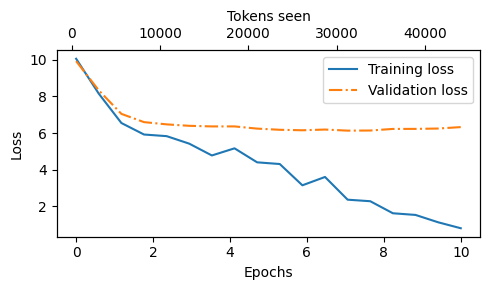

In [ ]:
# visulaize training and validation losses
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):

    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()

    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The  Training and Validation losses start to diverge which means that the model is overfitting.The model memorizes the training data by searching for the generated text like "quite insensible to the irony" found in the "The Verdict" text. The small training dataset and the multiple epochs lead to model memorization. Sampling methods used by LLMs mitigates it.

In [ ]:
# save the model parameters with state_dict mapping each layer to its parameters
torch.save(model.state_dict(), "model.pth")

In [ ]:
# save model and the adaptive optimizer AdamW stored additional parameters
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [ ]:
# to restore the model need to load the saved params and the use load_state_dict
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()